## Coordinates

### Inputs

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from iris_lmsalpy import extract_irisL2data as ei
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.io import fits
import rebin

from iris_lmsalpy import extract_irisL2data as ei
import pick_from_LMSAL
import my_fits

/Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/


### Getting IRIS + AIA arrays

In [2]:
obsid, numraster = '20211015_051453_3600009176', 0
#obsid, numraster = '20220607_202829_3620106067', 0
iris_file = pick_from_LMSAL.obsid_raster(obsid, raster=numraster)
#aia_file = pick_from_LMSAL.obsid_raster2aia(obsid, raster=numraster)
aia_file = pick_from_LMSAL.obsid_raster2aia(obsid, raster=numraster, pattern='1600')

aia_data = my_fits.read(aia_file[0])
aia_1600 = aia_data[0]
hdr_aia_1600 = aia_data[1]
aia_middle_step = int(aia_1600.shape[0]//2)

aia_1600 = aia_1600[aia_middle_step,:,:]
info_1600 = my_fits.read(aia_file[0], ext=1)
xcen_aia = info_1600[0][:,10]
ycen_aia = info_1600[0][:,11]
#aia_middle_step = ei.get_ori_val(xcen_aia, a.raster['Mg II k 2796'].XCEN)

hdr_iris_data = ei.only_header(iris_file[0])
aux_hdr_iris_data = ei.only_header(iris_file[0], extension=1)
xcen_iris = hdr_iris_data['XCEN']
ycen_iris = hdr_iris_data['YCEN']
xscl_iris = aux_hdr_iris_data['CDELT3']
yscl_iris = aux_hdr_iris_data['CDELT2']
xscl_aia = hdr_aia_1600['CDELT1']
yscl_aia = hdr_aia_1600['CDELT2']
#
print()
print('IRIS coordinates: [{},{}]'.format(xcen_iris, ycen_iris))
print('AIA coordinates (closest ima. #{}): [{},{}]'.format(aia_middle_step, xcen_aia[aia_middle_step], ycen_aia[aia_middle_step]))
print()

Looking for... /irisa/data/level2/2021/10/15/20211015_051453_3600009176/*20211015_051453_3600009176*raster*_r00000.fits
/irisa/data/level2/2021/10/15/20211015_051453_3600009176/aia/
Looking for... /irisa/data/level2/2021/10/15/20211015_051453_3600009176/aia/aia*20211015_051453_3600009176*1600*.fits

Reading file /irisa/data/level2/2021/10/15/20211015_051453_3600009176/aia/aia_l2_20211015_051453_3600009176_1600.fits... 
Filename: /irisa/data/level2/2021/10/15/20211015_051453_3600009176/aia/aia_l2_20211015_051453_3600009176_1600.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   (555, 383, 565)   int16   
  1                1 ImageHDU        27   (20, 565)   float64   
  2                1 TableHDU        28   565R x 4C   [A0, A0, A0, A101]   

Reading file /irisa/data/level2/2021/10/15/20211015_051453_3600009176/aia/aia_l2_20211015_051453_3600009176_1600.fits... 
Filename: /irisa/data/level2/2021/10/15/20211015_051453_3600009176/

### Visualizing AIA

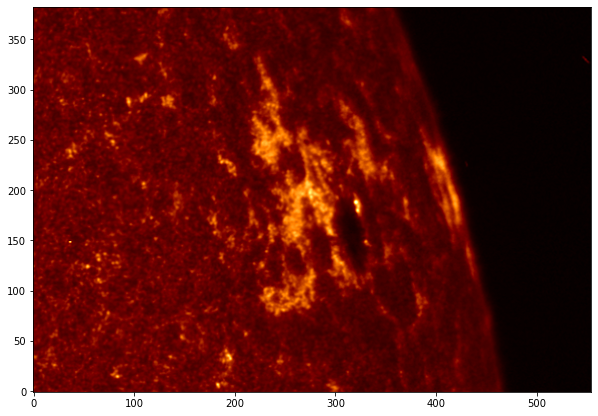

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[10,8])
ax.imshow(aia_1600, cmap='afmhot', origin="lower")#, cmap=cm.sdoaia1600)

In [4]:
print("center in arcsec", ycen_aia[aia_middle_step], xcen_aia[aia_middle_step])
print("scaling", yscl_aia, xscl_aia)
print("shape in pixels", aia_1600.shape)

print("shape in arcsec should be around", 400, 1050-640+10)

try_aia = aia_1600.shape[0]*yscl_aia, aia_1600.shape[1]*xscl_aia
print("shape in arcsec", try_aia)

center in arcsec 251.23995971679688 842.9383544921875
scaling 0.600000023842 0.600000023842
shape in pixels (383, 555)
shape in arcsec should be around 400 420
shape in arcsec (229.800009131486, 333.00001323231004)


In [5]:
print("current center is:", aia_1600.shape[0]/2, aia_1600.shape[1]/2)
print("center should be:", xcen_aia[aia_middle_step], ycen_aia[aia_middle_step])

new_aia = rebin.congrid(aia_1600, try_aia)

print("new center is:", new_aia.shape[0]/2, new_aia.shape[1]/2)

current center is: 191.5 277.5
center should be: 842.9383544921875 251.23995971679688
new center is: 115.0 167.0


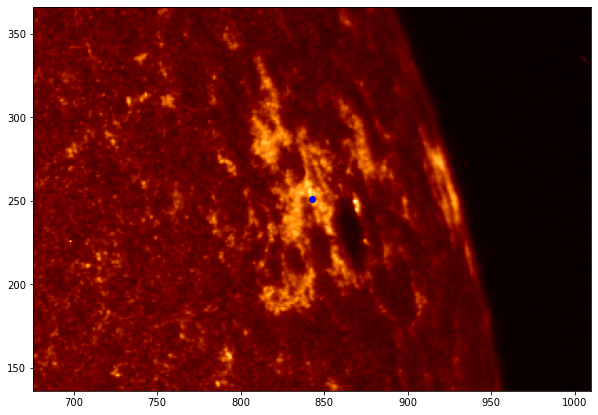

In [52]:
haia, waia = new_aia.shape
#print(waia, haia)
extent_aia = [xcen_aia[aia_middle_step]-waia/2,xcen_aia[aia_middle_step]+waia/2,ycen_aia[aia_middle_step]-haia/2,ycen_aia[aia_middle_step]+haia/2]
#print(extent_aia)

fig, ax = plt.subplots(figsize=[10,8])
ax.imshow(new_aia, cmap='afmhot', extent=extent_aia, origin="lower")
plt.plot(xcen_aia[aia_middle_step], ycen_aia[aia_middle_step], marker="o", color="blue")

### Visualizing IRIS

In [7]:
iris_raster = ei.load(iris_file[0])

extent_hx_hy = iris_raster.raster['Mg II k 2796'].extent_heliox_helioy
iris_data = iris_raster.raster['Mg II k 2796'].data

Creating temporary file...  /var/folders/_l/65mzxf5n2pn08nm56mps_lmm000ss_/T/tmp5b6ejqql
Loading... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz
Loading joblib file... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz

Suggested commands:
nist_short = nist['nist_short']
labels_nist = nist['labels_nist']
del nist


The varible types are:
nist_short : <class 'numpy.ndarray'>
labels_nist : <class 'numpy.ndarray'>

Mg II k 2796 754
Mg II k 2796 [2796.35, 0] 223
Loading joblib file... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz

Suggested commands:
nist_short = aux['nist_short']
labels_nist = aux['labels_nist']
del aux


The varible types are:
nist_short : <class 'numpy.ndarray'>
labels_nist : <class 'numpy.ndarray'>



In [147]:
iris_data.shape

(778, 320, 754)

In [148]:
iris_freq = 194

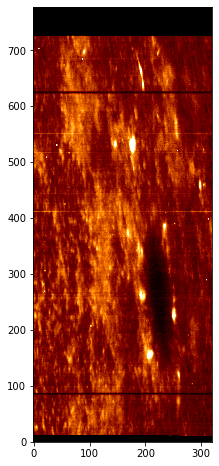

In [153]:
fig, ax = plt.subplots(figsize=[10,8])
ax.imshow(iris_data[:,:,iris_freq], cmap='afmhot', origin="lower", vmin=0, vmax=30)#, cmap=cm.sdoaia1600)

In [102]:
print("center in arcsec", ycen_iris, xcen_iris)
print("scaling", yscl_iris, xscl_iris)
print("shape in pixels", iris_data[:,:,iris_freq].shape)

new_iris_shape = iris_data[:,:,iris_freq].shape[0]*yscl_iris, iris_data[:,:,iris_freq].shape[1]*xscl_iris
print("scaled shape", new_iris_shape)

new_iris_data = rebin.congrid(iris_data[:,:,iris_freq], new_iris_shape)
print("scaled in arcsec", new_iris_data.shape)

print("shape in arcsec should be around", 240, 130)

center in arcsec 250.21 838.415
scaling 0.16635 0.349202051432
shape in pixels (778, 320)
scaled shape (129.4203, 111.74465645824)
scaled in arcsec (130, 112)
shape in arcsec should be around 240 130


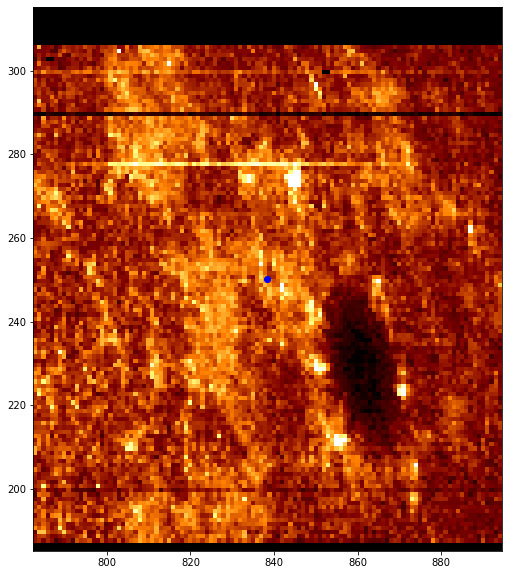

In [155]:
fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(new_iris_data, cmap='afmhot', origin = "lower", extent = extent_iris, vmin=0, vmax=30)

#### Crop IRIS

In [245]:
def crop_image(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]

In [257]:
cropped_iris = crop_image(new_iris_data)
hiris, wiris = cropped_iris.shape #in arcsec
print(wiris, hiris)
extent_iris = [xcen_iris-wiris/2,xcen_iris+wiris/2,ycen_iris-hiris/2,ycen_iris+hiris/2]
print(extent_iris)
print("center in pixels:", int(cropped_iris.shape[0]/2), ",", cropped_iris.shape[1]/2)
print("new center:", ycen_iris, xcen_iris)

112 119
[782.415, 894.415, 190.71, 309.71000000000004]
center in pixels: 59 , 56.0
new center: 250.21 838.415


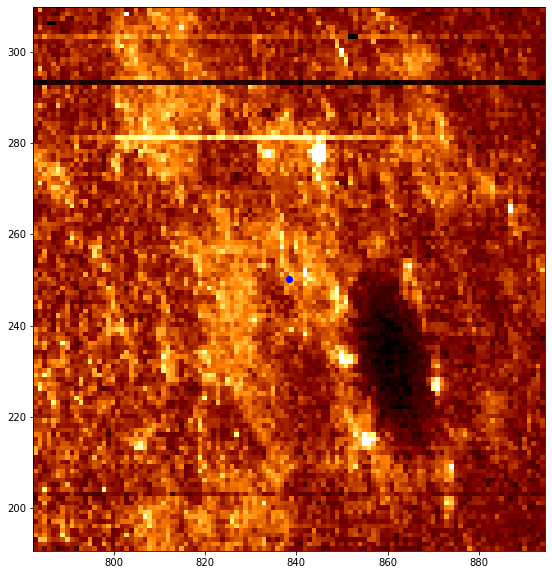

In [258]:
fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(cropped_iris, cmap='afmhot', origin = "lower", extent = extent_iris, vmin=0, vmax=30)
plt.plot(xcen_iris, ycen_iris, marker="o", color="blue")

### Cutting AIA to IRIS

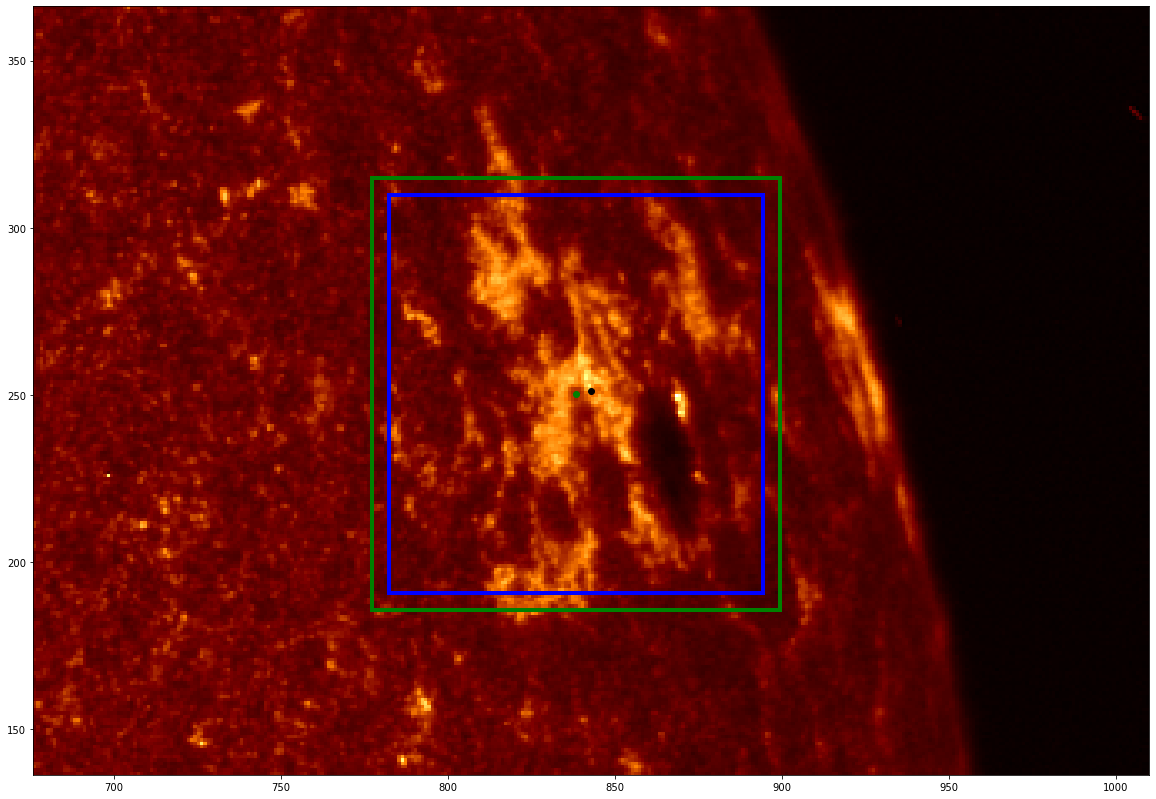

In [259]:
fig, ax = plt.subplots(figsize=[20,15])
ax.imshow(new_aia, cmap='afmhot', extent=extent_aia, origin="lower")
plt.plot(xcen_aia[aia_middle_step], ycen_aia[aia_middle_step], marker="o", color="black")

rect = patches.Rectangle((extent_iris[0], extent_iris[3]), extent_iris[1]-extent_iris[0], extent_iris[2]-extent_iris[3], linewidth=4, edgecolor='b', facecolor='none')
ax.add_patch(rect)

paddingr = patches.Rectangle((extent_iris[0]-5, extent_iris[3]+5), wiris+10, -hiris-10, linewidth=4, edgecolor='g', facecolor='none')
ax.add_patch(paddingr)

plt.plot(xcen_iris, ycen_iris, marker="o", color="green")

Notes
- AIA is not as same shown in <a href="https://www.lmsal.com/solarsoft/irisa/data/level2/2021/10/15/20211015_051453_3600009176/www/l2_20211015_051453_3600009176_SJI_2796_t000_fits_20211015_051522_context_1024.gif">here</a>
- seems to be slightly upward and different image ratio (not square, but rectangular)
- blue 

In [271]:
#in arcsec, crop points are:
acp = [(extent_iris[0]-5, extent_iris[3]+5), (extent_iris[0]-5, extent_iris[2]-5), (extent_iris[1]+5, extent_iris[3]+5), (extent_iris[1]+5, extent_iris[2]-5)]

#now, convert to pixels for cropping:
x_i = int(extent_iris[0]-5-extent_aia[0])
x_f = int(extent_iris[1]+5-extent_aia[0])

y_f = -int(extent_iris[3]+5-extent_aia[3])
y_i = -int(extent_iris[2]-5-extent_aia[3])

print(x_i, x_f, y_i, y_f)

101 223 180 51


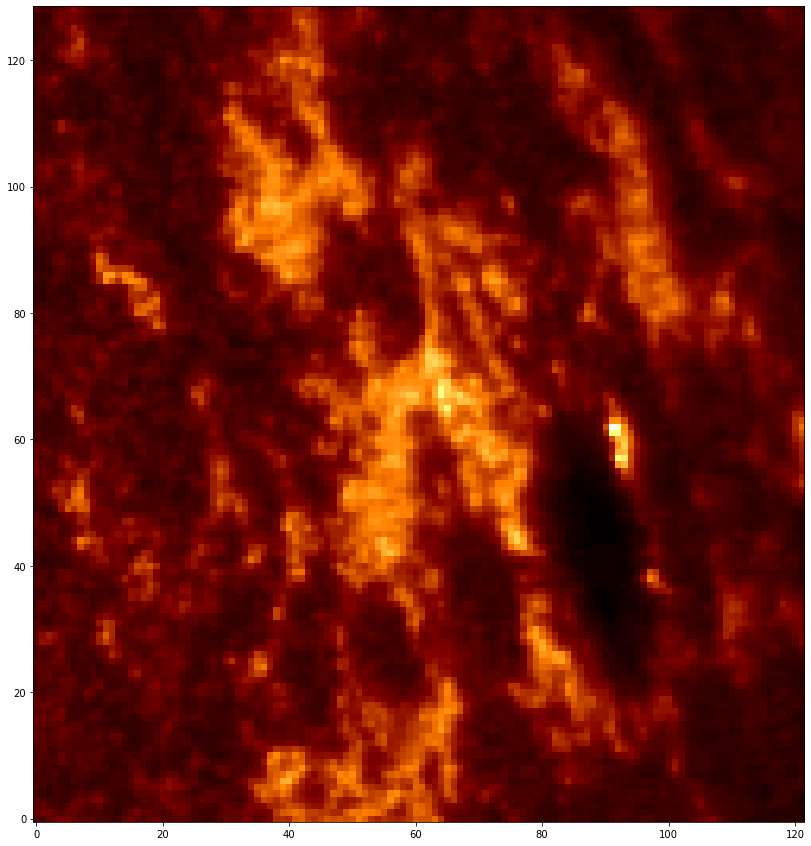

In [268]:
cut_aia = new_aia[y_f:y_i, x_i:x_f]

fig, ax = plt.subplots(figsize=[20,15])
ax.imshow(cut_aia, cmap='afmhot', origin="lower")

In [269]:
fig, ax = plt.subplots(1, 1, figsize=[10, 20])

for i in range(100):
    if (i%2 == 0):
        ax.imshow(cut_aia, cmap="afmhot", origin="lower")
    else:
        ax.imshow(cropped_iris, cmap='afmhot', origin="lower", vmin=0, vmax=30)
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(.5)

KeyboardInterrupt: 

### Saving Blanks for Alignment

In [293]:
import saveblank as sb
outpath = "/Users/jkim/Desktop/mg2hk/output/"

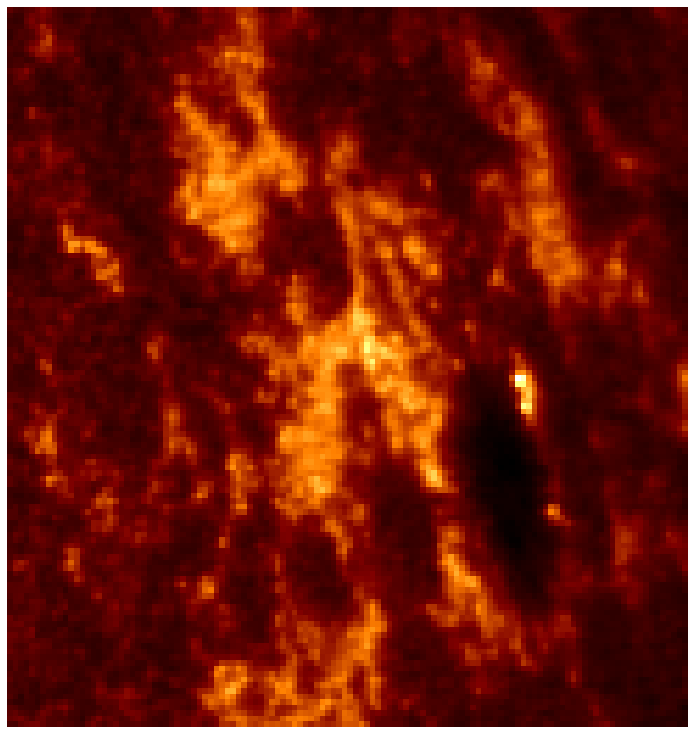

In [294]:
fig, ax = plt.subplots(figsize=[10,10])
ax.imshow(cut_aia, cmap='afmhot', origin="lower")
sb.saveblank(outpath, "aia_color_coord")

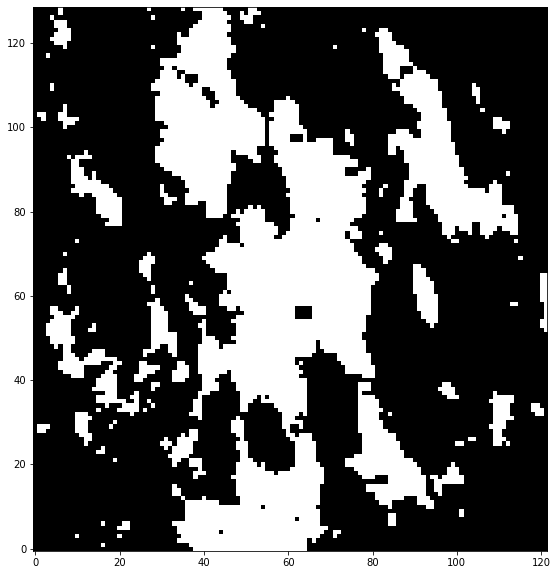

In [408]:
fig, ax = plt.subplots(figsize=[10,10])
ax.imshow(cut_aia>70, cmap='afmhot', origin="lower")
sb.saveblank(outpath, "aia_cut_coord")

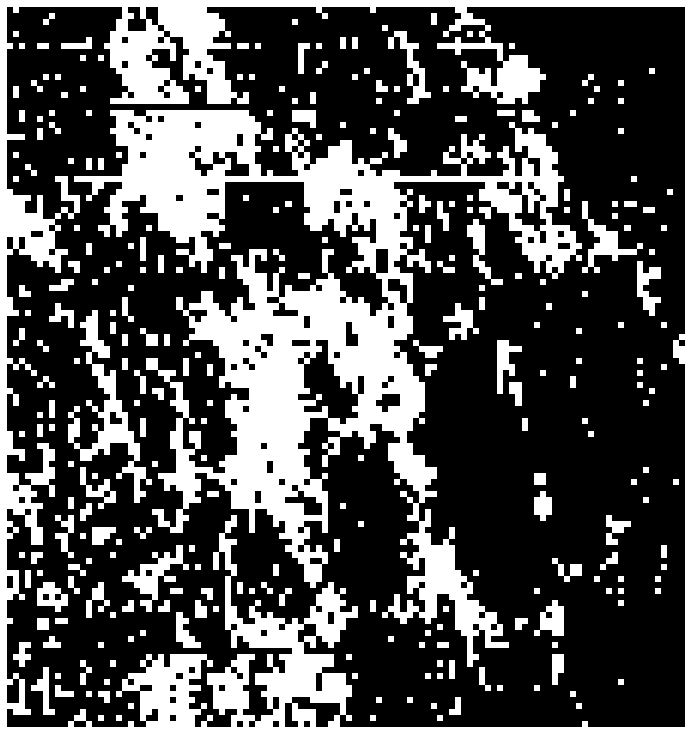

In [385]:
fig, ax = plt.subplots(1, 1, figsize=[10,10])

ax.imshow(cropped_iris>12, origin="lower", cmap="afmhot")
sb.saveblank(outpath, "iris_cut_coord")

In [386]:
print(cut_aia.shape)
print(new_iris_data.shape)

(129, 122)
(130, 112)


### RUNNING ALIGNMENT

In [387]:
os.system("python alignstable.py -i output/aia_cut_coord.png -t output/iris_cut_coord.png -c output/aia_color_coord.png -o output/result.png")

[INFO] loading images...
[INFO] aligning images...
blurred images
image dimensions:  (720, 680, 3)
RESULT SHAPE:  (720, 677, 3)


0

### Comparing Alignment Results

In [397]:
import matplotlib.image as mpimg

outputpath = "/Users/jkim/Desktop/mg2hk/output/result.png"
#outputpath = "/Users/jkim/Desktop/mg2hk/output/coord_manual.png"
result = mpimg.imread(outputpath)

#### Flicker before congrid

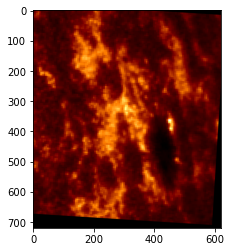

In [283]:
plt.imshow(result)

In [284]:
import matplotlib.pyplot as plt
from IPython import display

fig, ax = plt.subplots(1, 1, figsize=[10, 20])

for i in range(100):
    if (i%2 == 0):
        ax.imshow(result, cmap="afmhot")
    else:
        ax.imshow(cropped_iris, cmap='afmhot', origin="lower", vmin=0, vmax=30)
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(.5)

KeyboardInterrupt: 

#### Final Flicker/Comparison

In [398]:
result.shape

(720, 677, 3)

In [399]:
cropped_iris.shape

(119, 112)

In [400]:
new_result = result[:,:,0]

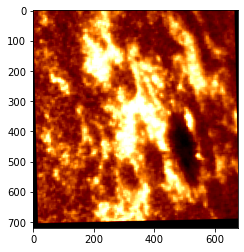

In [401]:
plt.imshow(new_result, cmap='afmhot')

In [402]:
newest = crop_image(new_result)

In [403]:
new_result.shape

(720, 677)

In [404]:
reshaped_result = rebin.congrid(newest, cropped_iris.shape)

In [405]:
fig, ax = plt.subplots(1, 1, figsize=[10, 20])

for i in range(100):
    if (i%2 == 0):
        ax.imshow(reshaped_result, cmap="afmhot")
    else:
        ax.imshow(cropped_iris, cmap='afmhot', origin="lower", vmin=0, vmax=30)
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(.5)

KeyboardInterrupt: 